# Bayesian introduction Jupyter notebook

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import scipy

#Some pretty colors I like
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [89]:
# Define the true function
def true_function_A(x):
    return 6*np.sin(x/3)


In [90]:
#Generating the data and using a fixed seed to reproduce results

np.random.seed(142857)
data_A_x=np.array([0.5,0.6,0.7,0.75,0.8,0.9,1.1,1.2,1.5,1.7,2.0])
data_A_errors=np.array([0.3,0.3,0.6,0.3,0.3,0.6,0.6,0.3,0.3,0.6,1])
data_A_y=np.random.multivariate_normal(true_function_A(data_A_x),np.diag(data_A_errors)**2)


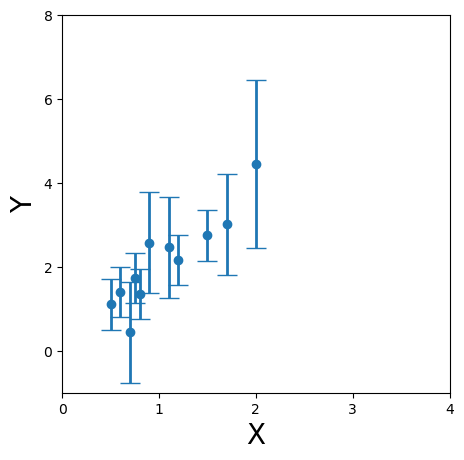

In [91]:
# Plot the data with error bars
fig, ax = plt.subplots(figsize=(5,5),dpi=100)
ax.errorbar(data_A_x, data_A_y, yerr=2*data_A_errors, fmt='o', linewidth=2,capsize=7,label='Data [95% Errors]',color=colors[0])

x_func = np.linspace(0, 2.5, 100)
# ax.plot(x_func, true_function_A(x_func), label='True Function',color=colors[1])

# plt.legend(fontsize=15,frameon=True, edgecolor='black')

# Set the axis labels and title
ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
# ax.set_title('Data with Error Bars')

plt.xlim(0,4)
plt.ylim(-1,8)

plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)
plt.show()


<font size="5">
The model we will use is:
    
    

$f(x,\alpha) = \alpha_1+\alpha_2x$

In [92]:
def model_A(x,params):
    return params[0]+params[1]*x

In [104]:

# Define the likelihood function for given errors sigma
def likelihood(params,arguments):
#     format for data=[xvals,yvals]
    data, model, sigmas = arguments
    likelihood_log_val=0

    for i in range(len(data[0])):
        likelihood_log_val=likelihood_log_val-1/2*((data[1][i] - model(data[0][i],params)) / sigmas[i])**2\
        -np.log(2*np.pi*sigmas[i]**2)/2
      
        
    return np.exp(likelihood_log_val)

# Define the prior function
def prior_model_A(params_vals,arguments):
    params0,params0_Cov_Inv_matrix=arguments
    mu=np.array(params_vals)-np.array(params0)
    params_size=len(params_vals)
    return (2*np.pi)**(-params_size/2)*np.linalg.det(params0_Cov_Inv_matrix)**(-1)*np.exp(-np.dot(mu,np.dot(params0_Cov_Inv_matrix,mu))/2)



In [94]:
# Define the Metropolis algorithm
def metropolis(data,sigma, prior,prior_arguments, likelihood,model,\
               num_iterations, step_size):
#     step_size should be a list the size of the parameters of the model
    likelihood_arguments=[data, model, sigma]
    initial_parameters=prior_arguments[0]
    #thermalizing
    burn_samples=1000
    # Set the initial state of the chain
    params_current=initial_parameters
    params_list=[]
    posterior_list=[]
    
    acceptance_times=0
    
    cov_step_size=np.diag(step_size)**2
    
    posterior_current=(likelihood(params_current,likelihood_arguments))*(prior(params_current,\
                                                                               prior_arguments))
    
    # Run the Metropolis-Hastings algorithm for burning
    for i in range(burn_samples):
        # Propose a new state for the chain
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*(prior(params_proposed,\
                                                                               prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed


    for i in range(num_iterations):
        params_proposed=np.random.multivariate_normal(params_current,cov_step_size)
        
        posterior_proposed=(likelihood(params_proposed,likelihood_arguments))*\
        (prior(params_proposed,prior_arguments))
        
        # Calculate the acceptance probability
        acceptance_prob = min(1, posterior_proposed / posterior_current)

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            params_current = params_proposed
            posterior_current=posterior_proposed
            acceptance_times=acceptance_times+1

        # Store the current state
        params_list.append(params_current)
        posterior_list.append(posterior_current)
        
    
    #Rule of thumb acceptance is around 50%. 
    #You could plot the accuracy of the estimations as a function of this rate, that would be interesting to see. 
    print(acceptance_times/num_iterations*100,"%")
    
    return(np.array(params_list),np.array(posterior_list),\
           acceptance_times/num_iterations*100)



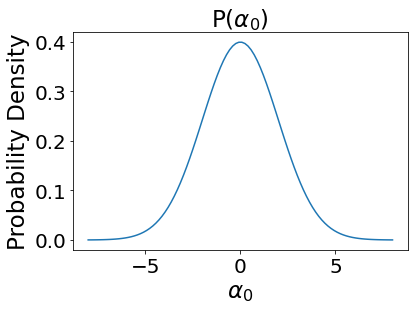

In [95]:


# Generate data for x-axis
x = np.linspace(-8,8, 100)

# Compute the corresponding y-values for the Gaussian distribution
y = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2/2**2)

# Plot the Gaussian distribution
plt.plot(x, y)

# Set plot labels and title
plt.xlabel(r'$\alpha_0$',fontsize=23)
plt.ylabel('Probability Density',fontsize=23)
plt.title(r'P($\alpha_0$)',fontsize=23)





plt.rc('xtick', labelsize=20)    
plt.rc('ytick', labelsize=20)
# Display the plot
plt.show()


# First case: known (and correct) errors

In [96]:
np.random.seed(142857)


prior_arguments_A=[[0,1],np.linalg.inv(np.diag([2**2,2**2]))]

results_A=metropolis([data_A_x,data_A_y],data_A_errors, prior_model_A,\
                         prior_arguments_A, likelihood,model_A,100000, [0.2,0.2])
all_chains =results_A[0]

40.174 %


In [97]:
#Taking 10000 samples from the visited posterior to estimate the percentiles in the model predictions

rng = np.random.default_rng()
alpha_rand = rng.choice(all_chains,(10000),replace=False)
func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]


In [98]:
alpha_rand

array([[-0.12580319,  1.9794558 ],
       [-0.38202584,  2.49431367],
       [ 0.35663313,  1.69593402],
       ...,
       [ 0.50186531,  1.5280941 ],
       [ 0.31931336,  1.38486939],
       [ 0.1342998 ,  1.80114797]])

In [105]:
val3=[]

for i in range(len(alpha_rand)):
    val3.append(model_A(3,alpha_rand[i]))

In [108]:
val3=np.array(val3)

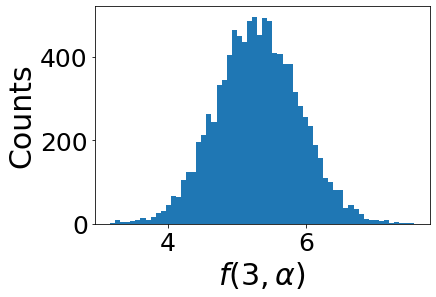

In [123]:
plt.hist(val3, bins=60)
plt.xlabel(r'$f(3,\alpha)$',fontsize=30)
plt.ylabel('Counts',fontsize=30)
plt.rc('xtick', labelsize=25)    # fontsize of the tick labels
plt.rc('ytick', labelsize=25)
plt.show()

Lets make a plot of the predictions of our calibrated model

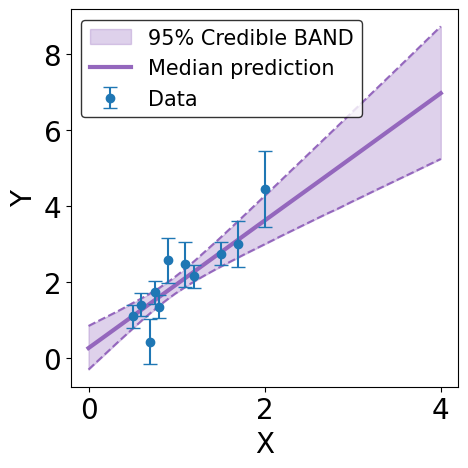

In [136]:
np.random.seed(142857)

x_func= np.linspace(0, 4, 200)
func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]






fig, ax = plt.subplots(figsize=(5,5),dpi=100)
median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))

prediction_color_number=4

lower = (np.percentile(func_rand, 2.5, axis = 0))






ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')


# ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.6)

ax.errorbar(data_A_x, data_A_y, yerr=data_A_errors, fmt='o', capsize=5,label='Data')


plt.legend(fontsize=15,frameon=True, edgecolor='black')


ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
# ax.set_title('Data with Error Bars')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)

plt.show()

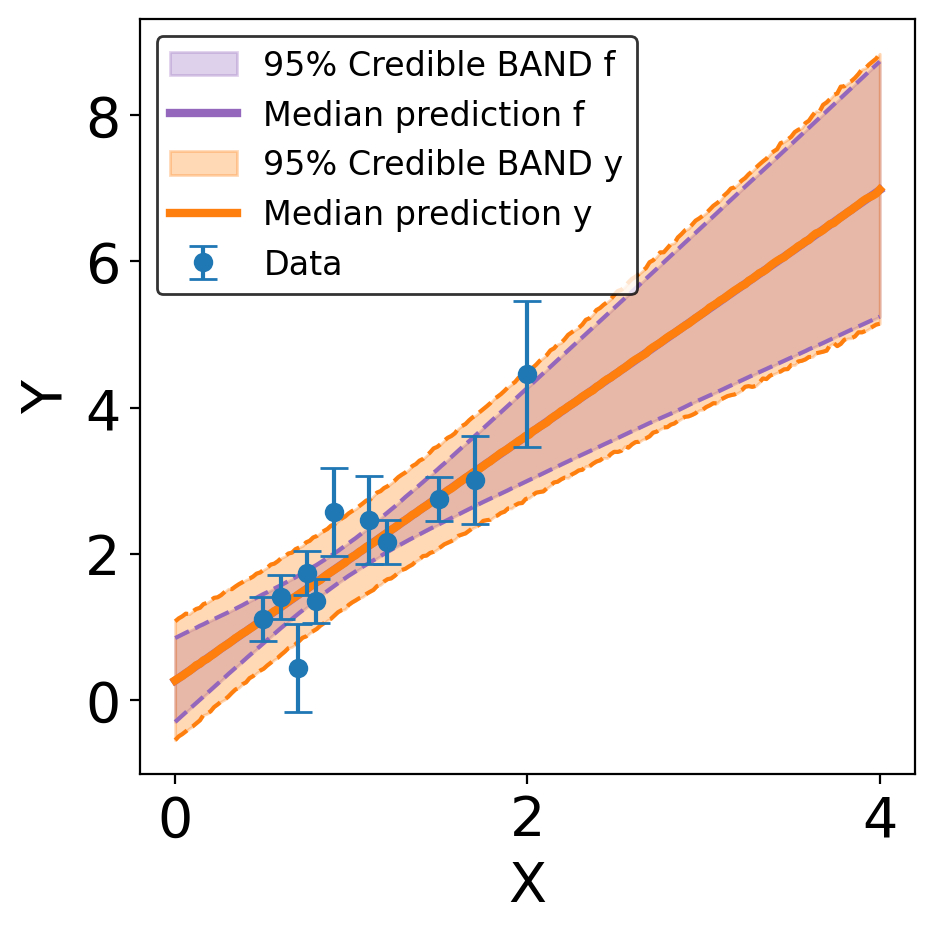

In [148]:
np.random.seed(142857)
fig, ax = plt.subplots(figsize=(5,5),dpi=200)

x_func= np.linspace(0, 4, 200)

func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]

median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))
lower = (np.percentile(func_rand, 2.5, axis = 0))

sigma_value=0.3
y_rand=[model_A(x_func,alpha) for alpha in alpha_rand]\
+ np.random.normal(0, sigma_value, size=(len(alpha_rand), len(x_func)) )

mediany = np.percentile(y_rand, 50, axis = 0)
uppery = (np.percentile(y_rand, 97.5, axis = 0))
lowery = (np.percentile(y_rand, 2.5, axis = 0))

ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number],
                alpha=0.3,label='95% Credible BAND f')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,
        label='Median prediction f')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')










prediction_color_number=4










y_color_number=1



ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND f')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction f')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')




ax.fill_between(x_func, lowery, uppery, color=colors[y_color_number], alpha=0.3,label='95% Credible BAND y')

ax.plot(x_func, mediany, color=colors[y_color_number],linewidth=3,label='Median prediction y')
ax.plot(x_func, lowery, color=colors[y_color_number],linestyle='dashed')
ax.plot(x_func, uppery, color=colors[y_color_number],linestyle='dashed')




# ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.6)

ax.errorbar(data_A_x, data_A_y, yerr=data_A_errors, fmt='o', capsize=5,label='Data')


plt.legend(fontsize=12,frameon=True, edgecolor='black')


ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
# ax.set_title('Data with Error Bars')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)



# plt.xlim(0,6)
# plt.ylim(-1,12)

plt.show()

And a plot of the posterior that we explored through the Metropolis algorithm

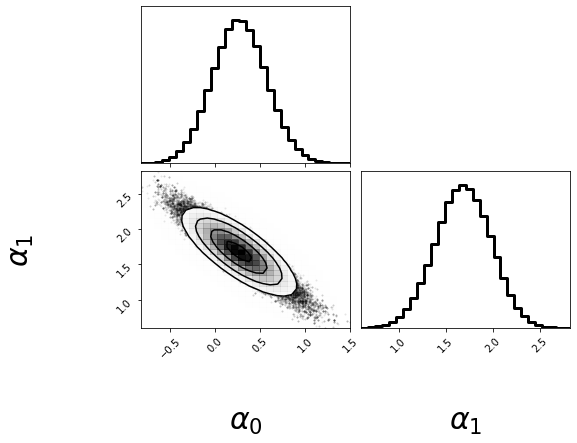

In [101]:

figure = corner.corner(all_chains,
    labels=[r'$\alpha_0$',r'$\alpha_1$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
#                        ,truths=[0,1], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)



In red we have the "true" values of the "true function" intercept and slope at zero. 

# Second case: Outlier (incorrect error scale)

Let's see what happens when one of our point has an under-reported uncertainty

In [365]:
np.random.seed(142857)


prior_arguments_A=[[0,1],np.diag([2,2])]

data_B_errors=np.copy(data_A_errors)

#We are artificially reducing the error of the sixth point by a factor of five
#and example of under-reported uncertainty
data_B_errors[5]=data_B_errors[5]/5

results_B=metropolis([data_A_x,data_A_y],data_B_errors, prior_model_A,\
                         prior_arguments_A, likelihood,model_A,100000, [0.2,0.2])
all_chainsB =results_B[0]

27.447 %


In [366]:
rng = np.random.default_rng()
alpha_rand = rng.choice(all_chainsB,(10000),replace=False)
func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]


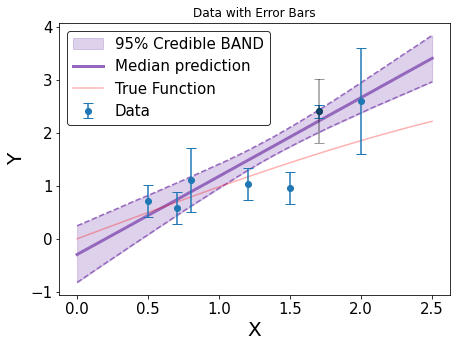

In [367]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))

prediction_color_number=4

lower = (np.percentile(func_rand, 2.5, axis = 0))






ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')




ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.3)

ax.errorbar(data_A_x, data_A_y, yerr=data_B_errors, fmt='o', capsize=5,label='Data')


ax.errorbar([data_A_x[5]], [data_A_y[5]], yerr=[data_A_errors[5]], fmt='o', capsize=5,color='k',alpha=0.4)


plt.legend(fontsize=15,frameon=True, edgecolor='black')

ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
ax.set_title('Data with Error Bars')
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)

plt.show()

Now the calibration and predictions are very much driven by that point, and we can see how our BAND does not contains the true function anymore. 

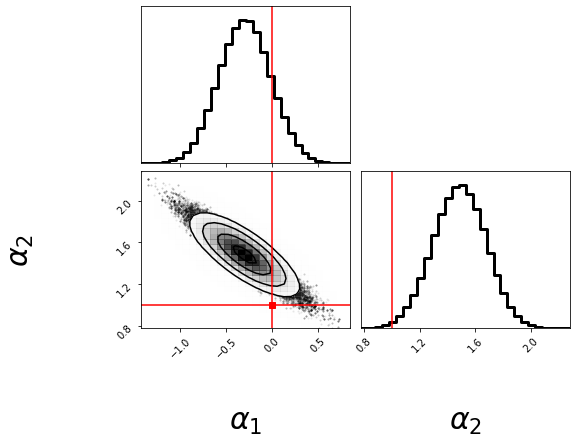

In [368]:
    
figure = corner.corner(all_chainsB,
    labels=[r'$\alpha_1$',r'$\alpha_2$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
                       ,truths=[0,1], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)
plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)



We of course miss the mark on the "true" value of the slope and intercept

# Third case: New data

Lets see now what happens when we measure a new point that seems to disagree with our current model

In [373]:
np.random.seed(142857)

data_C_x=np.concatenate((data_A_x,np.array([8])))
data_C_errors=np.concatenate((data_A_errors,np.array([0.4])))
data_C_y=data_C_y=np.concatenate(   (data_A_y,np.array([np.random.normal(true_function_A(data_C_x[-1]),data_C_errors[-1])])   ))


#If we use the same priors we had before, our distribution will be very influenced by it.
#Try changing these and see what happens!
prior_arguments_A=[[0,1],np.diag([4,4])]

results_C=metropolis([data_C_x,data_C_y],data_C_errors, prior_model_A,\
                         prior_arguments_A, likelihood,model_A,200000, [0.1,0.1])
all_chainsC =results_C[0]

42.0535 %


In [374]:
rng = np.random.default_rng()
alpha_rand = rng.choice(all_chainsC,(10000),replace=False)
func_rand=[model_A(x_func,alpha) for alpha in alpha_rand]


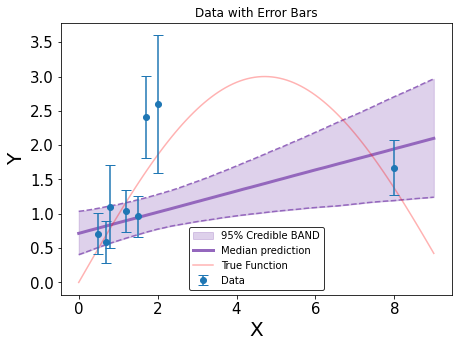

In [375]:
x_func= np.linspace(0, 9, 100)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))

prediction_color_number=4

lower = (np.percentile(func_rand, 2.5, axis = 0))






ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')




ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.3)

ax.errorbar(data_C_x, data_C_y, yerr=data_C_errors, fmt='o', capsize=5,label='Data')


plt.legend(fontsize=10,frameon=True, edgecolor='black')

ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
ax.set_title('Data with Error Bars')
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)

plt.show()

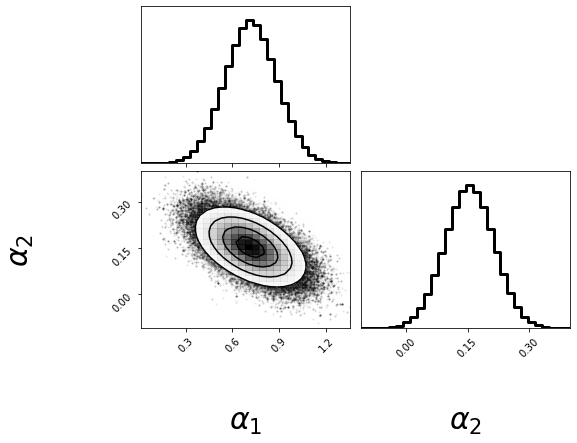

In [376]:
   
figure = corner.corner(all_chainsC,
    labels=[r'$\alpha_1$',r'$\alpha_2$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
                       ,truths=[0,1], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)


plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)


Lets try to extend our model with one more term

<font size="5">
The new model we will use is:
    
    

$f(x,\alpha) = \alpha_1+\alpha_2x+\alpha_3x^2$

In [337]:
def model_B(x,params):
    return params[0]+params[1]*x+params[2]*x**2

In [338]:
#Now our prior has three parameters instead of 2
prior_arguments_B=[[0,1,0],np.diag([4,4,4])]

results_D=metropolis([data_C_x,data_C_y],data_C_errors, prior_model_A,\
                         prior_arguments_B, likelihood,model_B,200000, [0.05,0.05,0.01])
all_chainsD =results_D[0]

47.7815 %


In [339]:
rng = np.random.default_rng()
alpha_rand = rng.choice(all_chainsD,(50000),replace=False)
func_rand=[model_B(x_func,alpha) for alpha in alpha_rand]

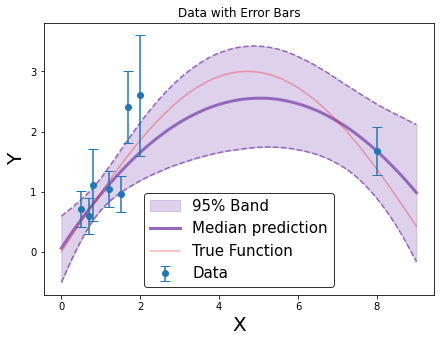

In [340]:
x_func= np.linspace(0, 9, 100)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
median = np.percentile(func_rand, 50, axis = 0)
upper = (np.percentile(func_rand, 97.5, axis = 0))

prediction_color_number=4

lower = (np.percentile(func_rand, 2.5, axis = 0))






ax.fill_between(x_func, lower, upper, color=colors[prediction_color_number], alpha=0.3,label='95% Credible BAND')

ax.plot(x_func, median, color=colors[prediction_color_number],linewidth=3,label='Median prediction')
ax.plot(x_func, lower, color=colors[prediction_color_number],linestyle='dashed')
ax.plot(x_func, upper, color=colors[prediction_color_number],linestyle='dashed')




ax.plot(x_func, true_function_A(x_func), label='True Function',color='r', alpha=0.3)

ax.errorbar(data_C_x, data_C_y, yerr=data_C_errors, fmt='o', capsize=5,label='Data')

plt.legend(fontsize=15,frameon=True, edgecolor='black')


ax.set_xlabel('X',fontsize=20)
ax.set_ylabel('Y',fontsize=20)
ax.set_title('Data with Error Bars')
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)

plt.show()

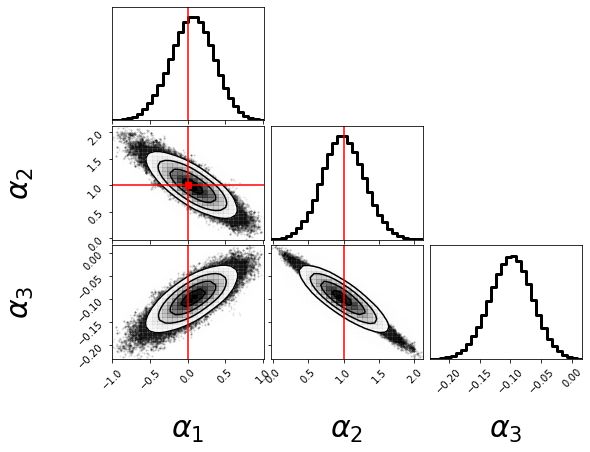

In [341]:
   
figure = corner.corner(all_chainsD,
    labels=[r'$\alpha_1$',r'$\alpha_2$',r'$\alpha_3$'],
    labelpad=0.2,
                       bins=30,
    label_kwargs={"fontsize":30},
                      hist_kwargs= {"linewidth":3},
    quantiles=None
                       ,truths=[0,1,1/2], truth_color='r'
                       ,
    smooth=(1.7)
                       ,
    smooth1d=1.0
                      )


width = 8
height = 6
figure.set_size_inches(width, height)


plt.rc('xtick', labelsize=15)    
plt.rc('ytick', labelsize=15)

And that is all folks!

Hope you had fun with this notebook. Some other cool things you could try to with it:

- Study the convergence of expectation values and the distributions themselves a as function of the total number of samples.
    - What happens if you keep only every other sample in the chain? Or only one every 20?

- Build an emulator from a Gaussian Process for the different models we played with. Of course these models are super fast to compute, the GP will be most likely slower, but it serves to practice how to orchestrate emulators with samplers for more challenging problems

- Incoorporate an error scale as part of your Bayesian estimation. This means not assuming that the reported error bars are correct, and you try to estimate the noise level at the same time as the parameters of the physical model.